In [123]:
#import packages

import pandas as pd
import twint
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
import re
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import textblob
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import sent_tokenize, word_tokenize

In [122]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacks\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## Get Tweet Data

Before we start to analyize the data, we need a collection of tweets. So let's use Twint to scrape Twitter for all tweets that mention Billie Eilish. She will be our pilot subject that we'll use to gather data on so that we can start getting insights on her audience. Let's gather all tweets from the last year with 'billie eilish' as our search keyword.

In [2]:
#need a function to scrape twitter data


# c = twint.Config()


# c.Format = "ID {id} | Tweet {tweet}"
# c.Search = 'billie eilish'
# c.Lang = 'en'
# c.Pandas_clean = True
# c.Since = '2019-03-31'
# c.Store_csv = True
# c.Output = 'tweets.csv'
# twint.run.Search(c)



## Data Cleaning

In [3]:
#lets read in the dataframe

df = pd.read_csv('tweets.csv')


In [4]:
#how many tweets did we get?

df.shape

(14556, 34)

In [5]:
#let's see if there's anything missing from our dataframe and see if we can get rid of anything

df.isna().sum()

id                     0
conversation_id        0
created_at             0
date                   0
time                   0
timezone               0
user_id                0
username               0
name                   0
place              14554
tweet                  0
mentions               0
urls                   0
photos                 0
replies_count          0
retweets_count         0
likes_count            0
hashtags               0
cashtags               0
link                   0
retweet                0
quote_url          13731
video                  0
near               14556
geo                14556
source             14556
user_rt_id         14556
user_rt            14556
retweet_id         14556
reply_to               0
retweet_date       14556
translate          14556
trans_src          14556
trans_dest         14556
dtype: int64

In [6]:
df.drop(['place', 'quote_url', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 
        'trans_src', 'trans_dest'], inplace=True, axis=1)

### Preprocess Raw Text



In [8]:
df['clean_tweets'] = df['tweet'].apply(lambda x: remove_links(x))

In [67]:
#remove numbers and stopwrds from tweets
def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)
    
    #remove urls from tweets

    result1 = re.sub(r"http\S+", "", letters_only_text)
    result2 = re.sub(r"pic.twitter\S+", "", result1)
    result3 = re.sub(r"https\S+", "", result2)

    # convert to lower case and split 
    words = result3.lower().split()
    

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    meaningful_words = [w for w in words if w not in stopword_set]

    # join the cleaned words in a list
    cleaned_word_list = " ".join(word.lower() for word in meaningful_words)
   
    result = re.sub(r"billieeilish", "billie eilish", cleaned_word_list)

    return result

In [68]:
df['clean_tweets'] = df['tweet'].apply(lambda x: preprocess(x))

In [11]:
#create another column where the words are lemmatized

lemmatizer = WordNetLemmatizer()

In [69]:
df['lemmatized_tweets'] = df['clean_tweets'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

### Save Cleaned data

In [70]:
clean_df = df.to_csv('clean_billie_tweets.csv')

## EDA

### Open clean dataframe

In [71]:
clean_df = pd.read_csv('clean_billie_tweets.csv', index_col=0)


In [24]:
#let's explore the distribution of tweets by date

tweets_by_date = clean_df.groupby('date')['tweet'].count().reset_index()

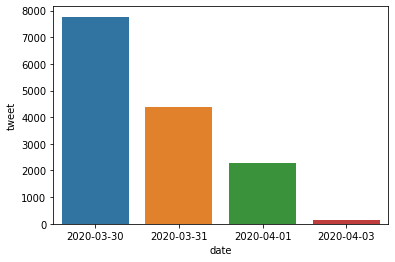

In [25]:
sns.barplot(data=tweets_by_date, x='date', y='tweet')

### Frequent Words

In [72]:
#let's visualize the most frequent words from the entire dataset

all_words = ' '.join([text for text in clean_df['clean_tweets'] if type(text) != float])


In [73]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)


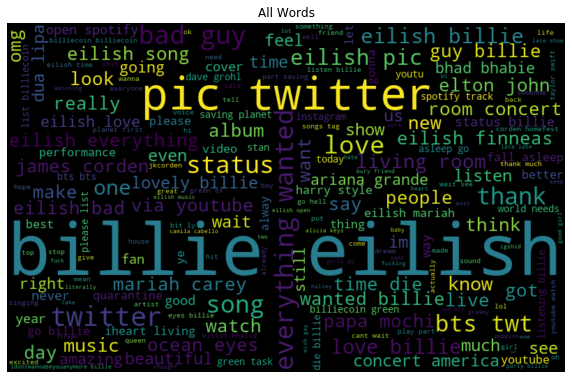

In [74]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words')
plt.show()

In [75]:
#lets look out wordclouds for each date

march30_df = clean_df[clean_df['date'] == '2020-03-30']
march31_df = clean_df[clean_df['date'] == '2020-03-31']
april1_df = clean_df[clean_df['date'] == '2020-04-01']

m30_words = ' '.join([text for text in march30_df['clean_tweets'] if type(text) != float])
m30_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(m30_words)


m31_words = ' '.join([text for text in march31_df['clean_tweets'] if type(text) != float])
m31_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(m31_words)


a1_words = ' '.join([text for text in april1_df['clean_tweets'] if type(text) != float])
a1_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(a1_words)


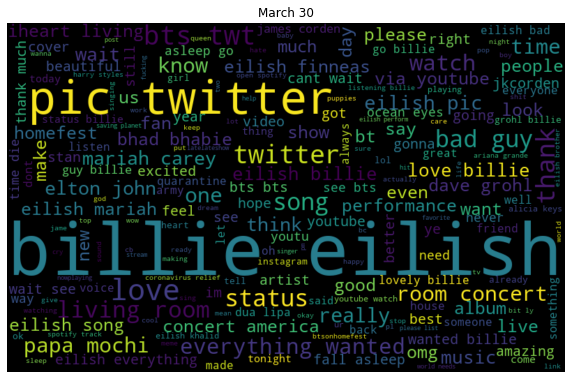

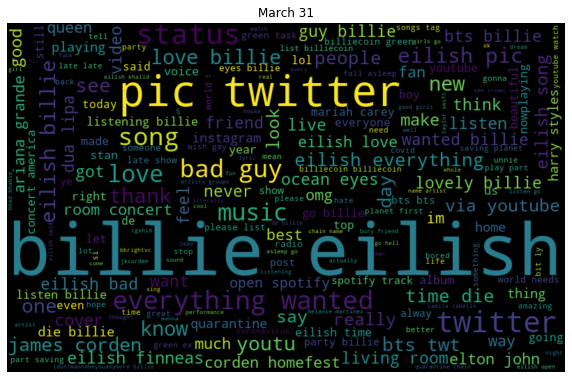

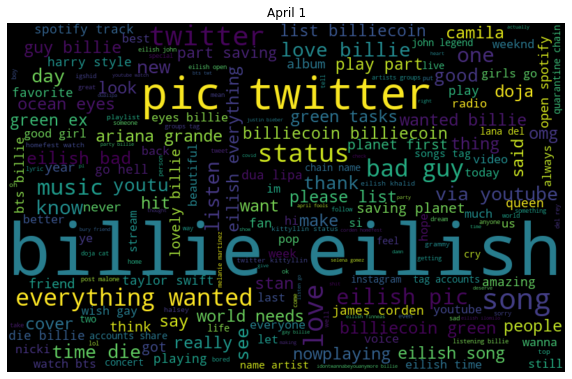

In [76]:


plt.figure(figsize=(10, 7))
plt.imshow(m30_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('March 30')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(m31_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('March 31')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(a1_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('April 1')
plt.show()

### TF-IDF
Let's calculate the importance of each word using TF-IDF scores. This will help us decide if there are other words we should be adding to our stopword list

In [104]:
#drop rows with nan values in tweets
clean_df.dropna(axis=0, subset=['clean_tweets'], inplace=True)

#### Vectorize Words

In [127]:
#create function to vectorize song

def count_vectorize(tweet, vocab=None):
    tokenized_tweet = word_tokenize(tweet)
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(tokenized_tweet))
    
    tweet_dict = {i:0 for i in unique_words}
    
    for word in tokenized_tweet:
        tweet_dict[word] += 1
    
    return tweet_dict

In [134]:
BoW = count_vectorize(clean_df['clean_tweets'][0])

In [135]:
#Term Frequency

#create term frequency function
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict

BoW_dict = term_frequency(BoW)

In [142]:
#create a list of dictionaries
def create_list_of_BoW(tweets):

    list_of_dictionaries = []

    for tweet in tweets:
        BoW = count_vectorize(tweet)

        list_of_dictionaries.append(BoW)
    return list_of_dictionaries

list_of_dictionaries = create_list_of_BoW(clean_df['clean_tweets'])


In [144]:
#Inverse Document Frequency
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

In [145]:
inverse_document_frequency(list_of_dictionaries)

{'cthdani': 9.58293787645873,
 'mumford': 8.889790695898785,
 'sumn': 8.889790695898785,
 'itsgwenmst': 9.58293787645873,
 'highest': 7.97349996402463,
 'heathers': 8.889790695898785,
 'normal': 7.280352783464685,
 'james': 3.7422962190853317,
 'zombies': 8.48432558779062,
 'approximately': 9.58293787645873,
 'qyp': 9.58293787645873,
 'reneezellweger': 9.58293787645873,
 'activity': 8.889790695898785,
 'stefaniereines': 9.58293787645873,
 'trillchart': 9.58293787645873,
 'wash': 7.791178407230675,
 'yaye': 9.58293787645873,
 'movies': 6.87488767535652,
 'koo': 9.58293787645873,
 'celiaseeme': 9.58293787645873,
 'reel': 9.58293787645873,
 'fromis': 9.58293787645873,
 'urilew': 9.58293787645873,
 'fcu': 9.58293787645873,
 'jooyoung': 9.58293787645873,
 'wozzlzix': 9.58293787645873,
 'drunken': 9.58293787645873,
 'revivalists': 9.58293787645873,
 'smiles': 8.48432558779062,
 'phizlair': 9.58293787645873,
 'khonprode': 9.58293787645873,
 'sino': 9.58293787645873,
 'dame': 9.58293787645873,